## Calculate volume of difference maps in polygon regions


In [1]:
import json
from shapely.geometry import Polygon, Point
from descartes.patch import PolygonPatch
import shapely.vectorized
import numpy as np
import pandas as pd
import rasterio # rasterio and OGR don't mix...see rasterio docs
import matplotlib.pyplot as plt
%matplotlib inline

#### Extract coordinates and maps from zipped file
This requires alot of memory

In [2]:
npzf = np.load("sandwich_maps.npz")
npzf.files
X=npzf['X']
Y=npzf['Y']
zmean=npzf['zmean']
zw = npzf['zw']

In [3]:
(num_maps,ysize,xsize)=np.shape(zw)
print(np.shape(npzf['zw']),num_maps,xsize,ysize)

(13, 6800, 8000) 13 8000 6800


#### Read a set of polygons that were saved in geojson format and build a shapely polygon

* Read the list of polygons (their names were not saved when exported from GlobalMapper)
* For each polygon, convert to a shapely Polygon

In [4]:
# array for masks
num_poly = 14
ma = np.empty((num_poly,ysize,xsize))
print(np.shape(ma))

(14, 6800, 8000)


Area of polygon: A1 3851.4 m^2
Area of polygon: A2 2628.6 m^2
Area of polygon: B1 4112.7 m^2
Area of polygon: B2 3026.3 m^2
Area of polygon: C1 5095.6 m^2
Area of polygon: C2 4037.0 m^2
Area of polygon: D1 10104.0 m^2
Area of polygon: D2 6086.1 m^2
Area of polygon: E1 5773.3 m^2
Area of polygon: E2 4431.7 m^2
Area of polygon: G1 2228.2 m^2
Area of polygon: G2 837.4 m^2
Area of polygon: F1 11898.5 m^2
Area of polygon: F2 4168.4 m^2


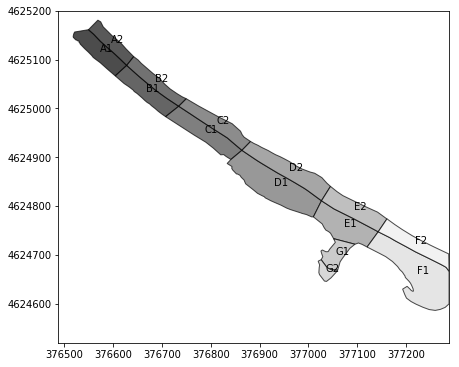

In [5]:
# plot all of the polygons
poly_names = ("A1","A2","B1","B2","C1","C2","D1","D2","E1","E2","G1","G2","F1","F2")

plt.figure(figsize=(7,7))
ax = plt.axes()
ax.set_aspect('equal')
# use bbox (bounding box) to set plot limits
plt.xlim(X[0][0],X[0][-1])
plt.ylim(Y[-1][0],Y[0][0])
with open('Volume_polygons.geojson') as f:
    data = json.load(f)
    i=0
    for feature in data['features']:
        # print(feature['geometry']['type'])
        
        # convert to array
        a=np.squeeze( feature['geometry']['coordinates'] )
        #print(np.shape(a))
        
        # shapely.geometry.Polygon requires a sequence of coordinate tuples
        poly = Polygon(tuple(map(tuple,a)))
        xc=poly.centroid.x
        yc=poly.centroid.y
        print("Area of polygon: {} {:.1f} m^2".format(poly_names[i],poly.area))
        fc = np.array([1.,1.,1.])*i/14.
        patch = PolygonPatch(poly, facecolor=fc, edgecolor=[0,0,0], alpha=0.7, zorder=2)
        ax.add_patch(patch)
        plt.text(xc,yc,poly_names[i])
        i=i+1

In [6]:
# array for calulating areas
ones = np.ones((ysize,xsize))
# array for masks
num_poly = 14
ma = np.empty((num_poly,ysize,xsize))
print(np.shape(ma))

# arrays for areas
poly_areas = np.nan*np.ones(num_poly)
mask_areas = np.nan*np.ones(num_poly)

# arrays for polygon centroids
xc = np.nan*np.ones((num_poly))
yc = np.nan*np.ones((num_poly))

with open('Volume_polygons.geojson') as f:
    data = json.load(f)
    i=0
    for feature in data['features']:
        #print(feature['geometry']['type'])
        
        # convert to array
        a=np.squeeze( feature['geometry']['coordinates'] )
        
        # shapely.geometry.Polygon requires a sequence of coordinate tuples
        poly = Polygon(tuple(map(tuple,a)))
        xc[i]=poly.centroid.x
        yc[i]=poly.centroid.y
        poly_areas[i]=poly.area
        
        # raster mask
        ma[i,:,:] = shapely.vectorized.contains(poly,X,Y)
        
        # calculate area of mask
        area = np.sum(ma[i,:,:]*ones)*.1*.1
        mask_areas[i]=area
        print("{} Polygon area: {:.1f}; Mask area: {:.1f}".format(poly_names[i],poly_areas[i],mask_areas[i]))
        i = i+1


(14, 6800, 8000)
A1 Polygon area: 3851.4; Mask area: 3850.4
A2 Polygon area: 2628.6; Mask area: 2627.9
B1 Polygon area: 4112.7; Mask area: 4111.5
B2 Polygon area: 3026.3; Mask area: 3025.5
C1 Polygon area: 5095.6; Mask area: 5094.3
C2 Polygon area: 4037.0; Mask area: 4035.8
D1 Polygon area: 10104.0; Mask area: 10101.1
D2 Polygon area: 6086.1; Mask area: 6084.5
E1 Polygon area: 5773.3; Mask area: 5771.8
E2 Polygon area: 4431.7; Mask area: 4430.4
G1 Polygon area: 2228.2; Mask area: 2227.7
G2 Polygon area: 837.4; Mask area: 837.1
F1 Polygon area: 11898.5; Mask area: 11892.0
F2 Polygon area: 4168.4; Mask area: 4167.3


In [8]:
# list of dates for use as titles / column headers
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May_2017",\
         "18-Sep-2017",\
#         "03-Jan-2017",\
         "10-Jan-2018"]
         )
print(len(titles))

13


### delz is estimated uncertainty of elevation measurements

In [40]:

delz = 0.07
qdelz = np.sqrt(2*delz**2)
print("qdelz = ",qdelz)

qdelz =  0.0989949493661


In [41]:
### calculate volume changes for last minus first maps

In [43]:
# make a dataframe to hold the results
df = pd.DataFrame(columns=poly_names,index=("Poly areas","Mask areas"))
df.loc["Poly areas"]=poly_areas
df.loc["Mask areas"]=mask_areas
df.round(1)

# calculate total volume change between last and first maps
dz = zw[-1,:,:]-zw[0,:,:]
has_data = np.ones((ysize,xsize))
has_data[np.isnan(dz)]=0.
#plt.imshow(has_data)

pv = np.nan*np.ones((num_poly))
pa = np.nan*np.ones((num_poly))
pve = np.nan*np.ones((num_poly))
tot_area = 0.
tot_vol = 0.

tname = titles[-1]+" - "+titles[0]
fname = titles[-1]+"_minus_"+titles[0]+".png"
csvname = titles[j+1]+"_minus_"+titles[j]+".csv"
csvf =  file = open(csvname, "w")
csvf.write(tname+"\n")
csvf.write("Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area\n")
print(tname)
print("Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area")

for i in range(num_poly):
    pdz = ma[i,:,:]*dz
    pdz[np.isnan(pdz)]=0.
    pa[i] = np.sum(ma[i,:,:]*has_data)*.1*.1
    pv[i] = np.sum(pdz)*.1*.1
    pve[i] = qdelz*pa[i]
    tot_area = tot_area+pa[i]
    tot_vol = tot_vol+pv[i]
    s = "{:s}, {:7.1f}, {:8.1f},  {:8.1f}, {:4.1f}, {:.1f}".\
    format(poly_names[i],pa[i],pv[i],pve[i],pv[i]/pa[i],100.*pa[i]/mask_areas[i])
    print(s)
    csvf.write(s+"\n")
    
s="All, {:7.1f}, {:8.1f},,{:4.1f},".format(tot_area,tot_vol,tot_vol/tot_area)
print(s)
csvf.write(s+"\n")
csvf.close()

10-Jan-2018 - 22-Jan-2016
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4, -11286.1,     381.2, -2.9, 100.0
A2,  2627.9,  -2337.4,     260.2, -0.9, 100.0
B1,  4111.5,  -8213.5,     407.0, -2.0, 100.0
B2,  3025.5,  -1914.9,     299.5, -0.6, 100.0
C1,  5094.3,  -7642.7,     504.3, -1.5, 100.0
C2,  4035.8,  -1855.6,     399.5, -0.5, 100.0
D1, 10101.1,   2577.6,    1000.0,  0.3, 100.0
D2,  6084.5,    202.8,     602.3,  0.0, 100.0
E1,  5771.8,  -1295.7,     571.4, -0.2, 100.0
E2,  4430.4,   -322.2,     438.6, -0.1, 100.0
G1,  2227.7,   -255.7,     220.5, -0.1, 100.0
G2,   837.1,   1007.6,      82.9,  1.2, 100.0
F1, 11892.0,  -2412.2,    1177.2, -0.2, 100.0
F2,  4167.3,  -1101.8,     412.5, -0.3, 100.0
All, 68257.2, -34850.0,,-0.5,


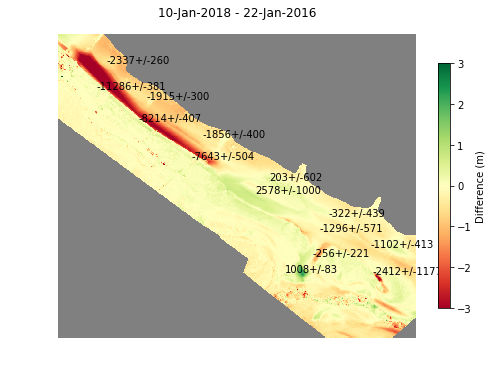

In [46]:
# plotting

# shift the text a little for readability
yoff = (-40.,0.,-30.,0.,-30.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.)
xoff = (0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,-40.,-30.,-30.,-30.)
fig=plt.figure(figsize=(8,6))
ax.set_aspect('equal')
cmap=plt.cm.RdYlGn
cmap.set_bad('grey')
plt.pcolormesh(X[0:-1:10],Y[0:-1:10],dz[0:-1:10],shading='flat',edgecolor=None,cmap=cmap,vmin=-3,vmax=3)
plt.axis('equal')
plt.xmin = X[0][0]
plt.xmax = X[0],[-1]
plt.ymin = Y[-1][0]
plt.ymax = Y[0][0]
plt.axis('off')
plt.title(tname)
cbar=plt.colorbar(shrink=0.75)
cbar.set_label('Difference (m)')
for i in range(num_poly):
    nstr = "{:.0f}+/-{:.0f}".format(pv[i],pve[i])
    plt.text(xc[i]+xoff[i],yc[i]+yoff[i],nstr)

plt.show()
fig.savefig(fname,dpi=200)  

In [ ]:
# calculate array of differences and plot difference maps
zdiff = np.zeros((num_maps-1,ysize,xsize))
zd = np.zeros((ysize,xsize))
for i in range(num_maps-1):
    zd = zw[i+1][:][:]-zw[i][:][:]
    zdiff[i][:][:]=zd

25-Jan-2016 - 22-Jan-2016
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,  -1714.7,     381.2,  -0.4, 100.0
A2,  2627.9,  -1207.2,     260.2,  -0.5, 100.0
B1,  4111.5,  -2077.9,     407.0,  -0.5, 100.0
B2,  3025.5,  -1044.2,     299.5,  -0.3, 100.0
C1,  5094.3,  -2007.5,     504.3,  -0.4, 100.0
C2,  4018.6,  -1434.5,     397.8,  -0.4, 99.6
D1, 10101.1,    457.0,    1000.0,   0.0, 100.0
D2,  6071.1,   -135.6,     601.0,  -0.0, 99.8
E1,  5771.8,   -125.0,     571.4,  -0.0, 100.0
E2,  4430.4,   -216.7,     438.6,  -0.0, 100.0
G1,  2227.7,    127.2,     220.5,   0.1, 100.0
G2,   837.1,     35.5,      82.9,   0.0, 100.0
F1, 11892.0,   -934.7,    1177.2,  -0.1, 100.0
F2,  4167.3,   -174.7,     412.5,  -0.0, 100.0
All, 68226.6, -10453.1,, -0.2,


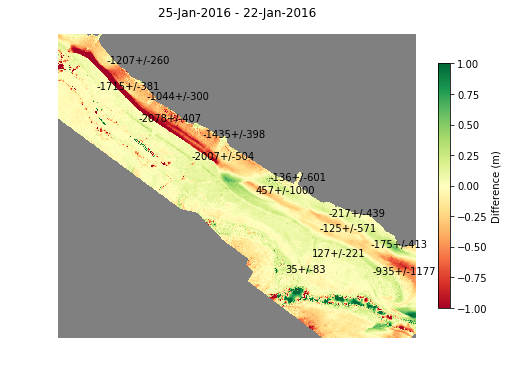

11-Feb-2016 - 25-Jan-2016
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,  -3299.4,     381.2,  -0.9, 100.0
A2,  2627.9,   -661.1,     260.2,  -0.3, 100.0
B1,  4111.5,  -2286.7,     407.0,  -0.6, 100.0
B2,  3025.5,   -706.6,     299.5,  -0.2, 100.0
C1,  5094.3,  -1692.3,     504.3,  -0.3, 100.0
C2,  4018.6,   -230.7,     397.8,  -0.1, 99.6
D1, 10101.1,   -144.8,    1000.0,  -0.0, 100.0
D2,  6071.1,   -615.0,     601.0,  -0.1, 99.8
E1,  5771.8,   -593.7,     571.4,  -0.1, 100.0
E2,  4430.4,   -196.7,     438.6,  -0.0, 100.0
G1,  2227.7,    121.6,     220.5,   0.1, 100.0
G2,   837.1,     72.3,      82.9,   0.1, 100.0
F1, 11892.0,  -2295.1,    1177.2,  -0.2, 100.0
F2,  4167.3,   -167.5,     412.5,  -0.0, 100.0
All, 68226.6, -12695.6,, -0.2,


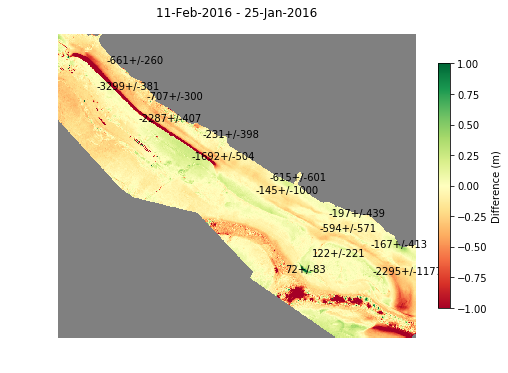

30-Mar-2016 - 11-Feb-2016
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,   -918.4,     381.2,  -0.2, 100.0
A2,  2627.9,    931.3,     260.2,   0.4, 100.0
B1,  4111.5,   -835.7,     407.0,  -0.2, 100.0
B2,  3025.5,   1740.1,     299.5,   0.6, 100.0
C1,  5094.3,  -1300.6,     504.3,  -0.3, 100.0
C2,  4035.8,    880.2,     399.5,   0.2, 100.0
D1, 10101.1,    770.5,    1000.0,   0.1, 100.0
D2,  6084.5,   1394.2,     602.3,   0.2, 100.0
E1,  5771.8,    680.1,     571.4,   0.1, 100.0
E2,  4430.4,    636.4,     438.6,   0.1, 100.0
G1,  2227.7,    -27.3,     220.5,  -0.0, 100.0
G2,   837.1,    -55.0,      82.9,  -0.1, 100.0
F1, 11892.0,   1511.8,    1177.2,   0.1, 100.0
F2,  4167.3,    -44.3,     412.5,  -0.0, 100.0
All, 68257.2,   5363.2,,  0.1,


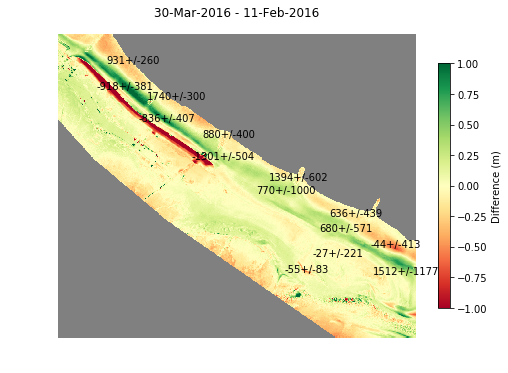

21-Sep-2016 - 30-Mar-2016
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,   -454.8,     381.2,  -0.1, 100.0
A2,  2627.9,   -560.1,     260.2,  -0.2, 100.0
B1,  4111.5,    203.6,     407.0,   0.0, 100.0
B2,  3025.5,   -274.8,     299.5,  -0.1, 100.0
C1,  5094.3,    -50.5,     504.3,  -0.0, 100.0
C2,  4035.8,    225.1,     399.5,   0.1, 100.0
D1, 10101.1,    629.7,    1000.0,   0.1, 100.0
D2,  6084.5,    -57.8,     602.3,  -0.0, 100.0
E1,  5771.8,    412.8,     571.4,   0.1, 100.0
E2,  4430.4,   -409.9,     438.6,  -0.1, 100.0
G1,  2227.7,    -63.5,     220.5,  -0.0, 100.0
G2,   837.1,   -107.5,      82.9,  -0.1, 100.0
F1, 11892.0,    998.1,    1177.2,   0.1, 100.0
F2,  4167.3,  -1022.6,     412.5,  -0.2, 100.0
All, 68257.2,   -532.3,, -0.0,


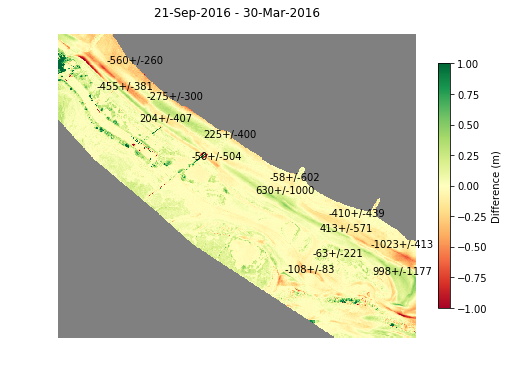

09-Jan-2017 - 21-Sep-2016
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,     50.6,     381.2,   0.0, 100.0
A2,  2627.9,   -824.7,     260.2,  -0.3, 100.0
B1,  4111.5,    217.3,     407.0,   0.1, 100.0
B2,  3025.5,  -1238.8,     299.5,  -0.4, 100.0
C1,  5094.3,    884.5,     504.3,   0.2, 100.0
C2,  4035.8,  -1089.9,     399.5,  -0.3, 100.0
D1, 10101.1,   1580.7,    1000.0,   0.2, 100.0
D2,  6084.5,   -281.9,     602.3,  -0.0, 100.0
E1,  5771.8,    681.5,     571.4,   0.1, 100.0
E2,  4430.4,    304.6,     438.6,   0.1, 100.0
G1,  2227.7,     80.5,     220.5,   0.0, 100.0
G2,   837.1,    -43.0,      82.9,  -0.1, 100.0
F1, 11892.0,   2580.3,    1177.2,   0.2, 100.0
F2,  4167.3,    439.7,     412.5,   0.1, 100.0
All, 68257.2,   3341.5,,  0.0,


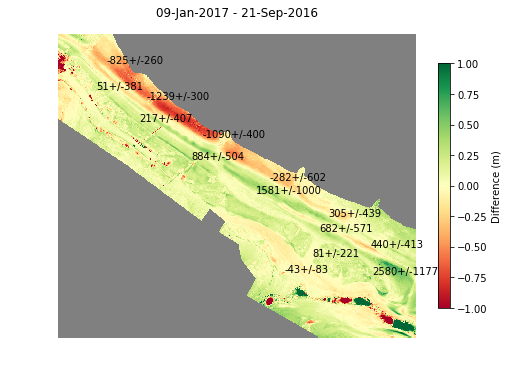

25-Jan-2017 - 09-Jan-2017
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,   -365.9,     381.2,  -0.1, 100.0
A2,  2627.9,    288.6,     260.2,   0.1, 100.0
B1,  4111.5,   -559.4,     407.0,  -0.1, 100.0
B2,  3025.5,    181.9,     299.5,   0.1, 100.0
C1,  5094.3,   -840.8,     504.3,  -0.2, 100.0
C2,  4035.8,   -269.7,     399.5,  -0.1, 100.0
D1, 10101.1,   -348.3,    1000.0,  -0.0, 100.0
D2,  6084.5,    920.6,     602.3,   0.2, 100.0
E1,  5771.8,   -419.9,     571.4,  -0.1, 100.0
E2,  4430.4,   -520.6,     438.6,  -0.1, 100.0
G1,  2227.7,   -138.6,     220.5,  -0.1, 100.0
G2,   837.1,    -53.6,      82.9,  -0.1, 100.0
F1, 11892.0,  -2502.4,    1177.2,  -0.2, 100.0
F2,  4167.3,   -794.5,     412.5,  -0.2, 100.0
All, 68257.2,  -5422.4,, -0.1,


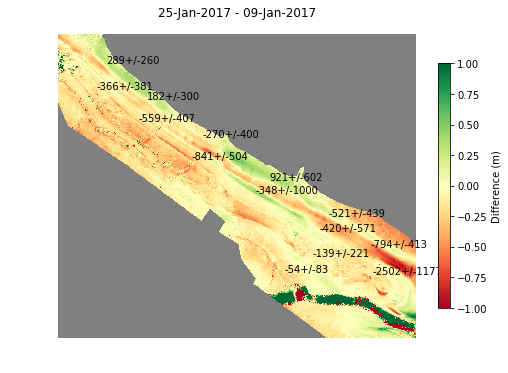

14-Feb-2017 - 25-Jan-2017
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,  -1918.0,     381.2,  -0.5, 100.0
A2,  1246.4,   -326.2,     123.4,  -0.3, 47.4
B1,  4111.5,  -1345.9,     407.0,  -0.3, 100.0
B2,  2708.0,   -622.0,     268.1,  -0.2, 89.5
C1,  5094.3,  -1392.9,     504.3,  -0.3, 100.0
C2,  3392.5,   -458.9,     335.8,  -0.1, 84.1
D1, 10101.1,   -142.4,    1000.0,  -0.0, 100.0
D2,  5112.4,   -850.4,     506.1,  -0.2, 84.0
E1,  5771.8,   -407.3,     571.4,  -0.1, 100.0
E2,  4359.1,    -14.3,     431.5,  -0.0, 98.4
G1,  2227.7,     19.1,     220.5,   0.0, 100.0
G2,   837.1,    126.3,      82.9,   0.2, 100.0
F1, 11892.0,    134.4,    1177.2,   0.0, 100.0
F2,  3939.3,    435.1,     390.0,   0.1, 94.5
All, 64643.7,  -6763.7,, -0.1,


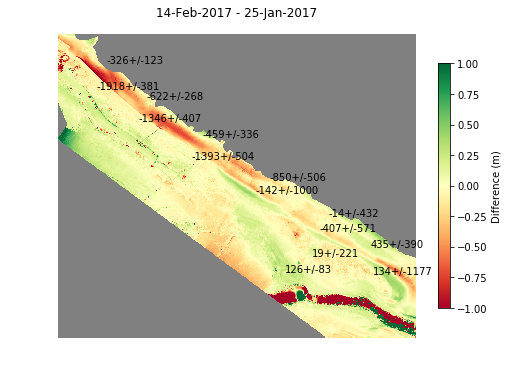

16-Mar-2017 - 14-Feb-2017
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,   -112.9,     381.2,  -0.0, 100.0
A2,  1246.4,    341.3,     123.4,   0.3, 47.4
B1,  4111.5,     75.8,     407.0,   0.0, 100.0
B2,  2708.0,    207.7,     268.1,   0.1, 89.5
C1,  5094.3,    254.8,     504.3,   0.1, 100.0
C2,  3392.5,    362.0,     335.8,   0.1, 84.1
D1, 10101.1,    313.2,    1000.0,   0.0, 100.0
D2,  5112.4,   1203.6,     506.1,   0.2, 84.0
E1,  5771.8,    510.5,     571.4,   0.1, 100.0
E2,  4359.1,    344.8,     431.5,   0.1, 98.4
G1,  2227.7,    -30.7,     220.5,  -0.0, 100.0
G2,   837.1,    -32.9,      82.9,  -0.0, 100.0
F1, 11892.0,   1166.1,    1177.2,   0.1, 100.0
F2,  3939.3,   -204.6,     390.0,  -0.1, 94.5
All, 64643.7,   4398.8,,  0.1,


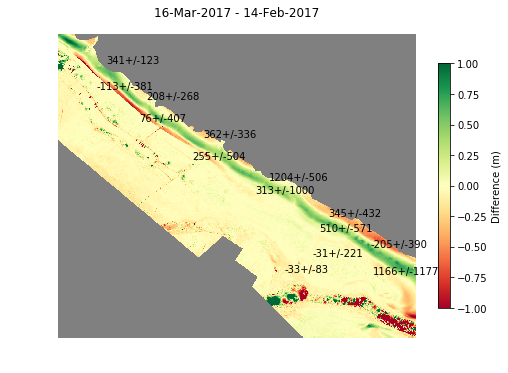

28-Apr-2017 - 16-Mar-2017
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,   -285.5,     381.2,  -0.1, 100.0
A2,  2627.9,   -115.3,     260.2,  -0.0, 100.0
B1,  4111.5,     -8.0,     407.0,  -0.0, 100.0
B2,  3025.5,    394.8,     299.5,   0.1, 100.0
C1,  5094.3,    530.3,     504.3,   0.1, 100.0
C2,  4035.8,   -412.5,     399.5,  -0.1, 100.0
D1, 10101.1,    494.5,    1000.0,   0.0, 100.0
D2,  6055.3,  -1758.5,     599.4,  -0.3, 99.5
E1,  5771.8,    337.2,     571.4,   0.1, 100.0
E2,  4430.4,   -998.8,     438.6,  -0.2, 100.0
G1,  2227.7,    -27.8,     220.5,  -0.0, 100.0
G2,   837.1,    -29.7,      82.9,  -0.0, 100.0
F1, 11892.0,    625.8,    1177.2,   0.1, 100.0
F2,  4167.3,   -781.8,     412.5,  -0.2, 100.0
All, 68228.1,  -2035.3,, -0.0,


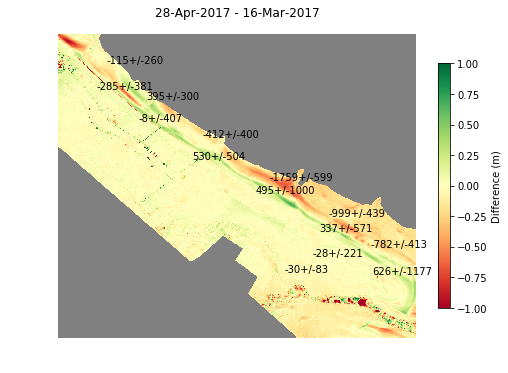

04-May_2017 - 28-Apr-2017
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,    -15.9,     381.2,  -0.0, 100.0
A2,  2627.9,     55.5,     260.2,   0.0, 100.0
B1,  4111.5,     -5.7,     407.0,  -0.0, 100.0
B2,  3025.5,    -21.9,     299.5,  -0.0, 100.0
C1,  5094.3,    -58.3,     504.3,  -0.0, 100.0
C2,  4035.8,    -67.1,     399.5,  -0.0, 100.0
D1, 10101.1,   -195.5,    1000.0,  -0.0, 100.0
D2,  6055.3,    117.0,     599.4,   0.0, 99.5
E1,  5771.8,    -24.3,     571.4,  -0.0, 100.0
E2,  4430.4,    114.1,     438.6,   0.0, 100.0
G1,  2227.7,      9.3,     220.5,   0.0, 100.0
G2,   837.1,     34.3,      82.9,   0.0, 100.0
F1, 11892.0,    425.8,    1177.2,   0.0, 100.0
F2,  4167.3,    311.1,     412.5,   0.1, 100.0
All, 68228.1,    678.3,,  0.0,


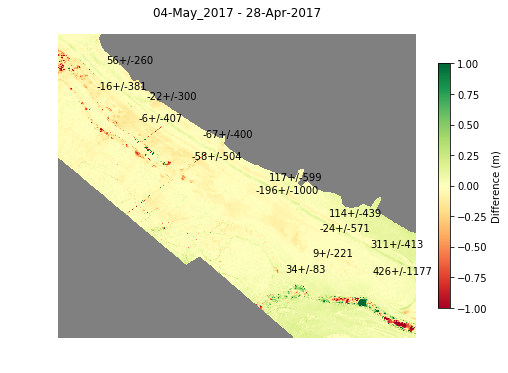

18-Sep-2017 - 04-May_2017
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,   1351.9,     381.2,   0.4, 100.0
A2,  2627.9,   -476.2,     260.2,  -0.2, 100.0
B1,  4111.5,   1119.5,     407.0,   0.3, 100.0
B2,  3025.5,   -626.0,     299.5,  -0.2, 100.0
C1,  5094.3,    594.1,     504.3,   0.1, 100.0
C2,  4035.8,   -571.7,     399.5,  -0.1, 100.0
D1, 10101.1,    850.2,    1000.0,   0.1, 100.0
D2,  6084.5,  -1056.6,     602.3,  -0.2, 100.0
E1,  5771.8,    839.2,     571.4,   0.1, 100.0
E2,  4430.4,   -543.5,     438.6,  -0.1, 100.0
G1,  2227.7,    112.0,     220.5,   0.1, 100.0
G2,   837.1,    -25.1,      82.9,  -0.0, 100.0
F1, 11892.0,   1187.3,    1177.2,   0.1, 100.0
F2,  4167.3,   -410.7,     412.5,  -0.1, 100.0
All, 68257.2,   2344.3,,  0.0,


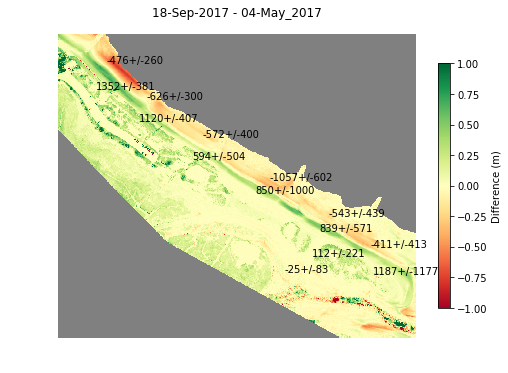

10-Jan-2018 - 18-Sep-2017
Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area
A1,  3850.4,  -3602.9,     381.2,  -0.9, 100.0
A2,  2627.9,    172.0,     260.2,   0.1, 100.0
B1,  4111.5,  -2710.7,     407.0,  -0.7, 100.0
B2,  3025.5,    138.5,     299.5,   0.0, 100.0
C1,  5094.3,  -2563.5,     504.3,  -0.5, 100.0
C2,  4035.8,   1230.8,     399.5,   0.3, 100.0
D1, 10101.1,  -1687.2,    1000.0,  -0.2, 100.0
D2,  6084.5,   1648.2,     602.3,   0.3, 100.0
E1,  5771.8,  -3186.6,     571.4,  -0.6, 100.0
E2,  4430.4,   1182.7,     438.6,   0.3, 100.0
G1,  2227.7,   -437.5,     220.5,  -0.2, 100.0
G2,   837.1,   1086.1,      82.9,   1.3, 100.0
F1, 11892.0,  -5309.6,    1177.2,  -0.4, 100.0
F2,  4167.3,   1342.9,     412.5,   0.3, 100.0
All, 68257.2, -12697.0,, -0.2,


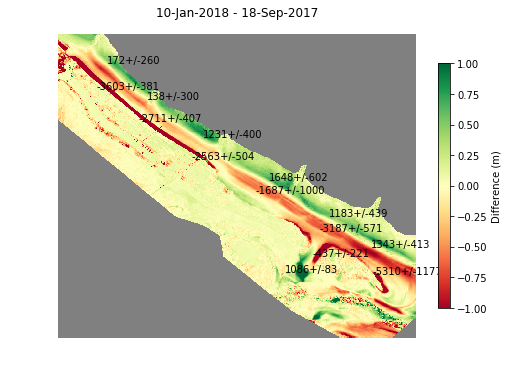

In [50]:
# Calculate volume change for all of the difference maps and all of the polygons
pv = np.nan*np.ones((num_poly,num_maps-1))
pa = np.nan*np.ones((num_poly,num_maps-1))
pve = np.nan*np.ones((num_poly,num_maps-1))
tot_area = np.zeros((num_maps-1))
tot_vol = np.zeros((num_maps-1))

for j in range(num_maps-1):
    tname = titles[j+1]+" - "+titles[j]
    fname = titles[j+1]+"_minus_"+titles[j]+".png"
    csvname = titles[j+1]+"_minus_"+titles[j]+".csv"

    csvf =  file = open(csvname, "w")
    csvf.write(tname+"\n")
    csvf.write("Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area\n")
    print(tname)
    print("Polygon, Area (m2), Volume diff (m3), Vol. uncert. (m3), Elev. diff (m), Pct area")

    zd = np.squeeze(zdiff[j,:,:])
    for i in range(num_poly):
        # make a mask with zeros where Nans are in diff map
        has_data = np.ones((ysize,xsize))
        has_data[np.isnan(zd)]=0.
        # mask with polygon        
        pdz = ma[i,:,:]*zd
        pdz[np.isnan(pdz)]=0.
        # calculate area
        pa[i,j] = np.sum(ma[i,:,:]*has_data)*.1*.1
        # calculate volume change
        pv[i,j] = np.sum(pdz)*.1*.1
        # rough estimate of uncertainty
        pve[i,j] = qdelz*pa[i,j]

        tot_area[j] = tot_area[j]+pa[i,j]
        tot_vol[j] = tot_vol[j]+pv[i,j]
        s = "{:s}, {:7.1f}, {:8.1f},  {:8.1f},  {:4.1f}, {:.1f}".\
            format(poly_names[i],pa[i,j],pv[i,j],pve[i,j],pv[i,j]/pa[i,j],100.*pa[i,j]/mask_areas[i])
        print(s)
        csvf.write(s+"\n")
    
    s="All, {:7.1f}, {:8.1f},, {:4.1f},".format(tot_area[j],tot_vol[j],tot_vol[j]/tot_area[j])
    print(s)
    csvf.write(s+"\n")
    csvf.close()
    
    # plotting
    yoff = (-40.,0.,-30.,0.,-30.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.)
    fig=plt.figure(figsize=(8,6))
    ax.set_aspect('equal')
    cmap=plt.cm.RdYlGn
    cmap.set_bad('grey')
    plt.pcolormesh(X[0:-1:10],Y[0:-1:10],zd[0:-1:10],shading='flat',edgecolor=None,cmap=cmap,vmin=-1,vmax=1)
    plt.axis('equal')
    plt.xmin = X[0][0]
    plt.xmax = X[0],[-1]
    plt.ymin = Y[-1][0]
    plt.ymax = Y[0][0]
    plt.axis('off')
    plt.title(tname)
    cbar=plt.colorbar(shrink=0.75)
    cbar.set_label('Difference (m)')
    for i in range(num_poly):
        nstr = "{:.0f}+/-{:.0f}".format(pv[i,j],pve[i,j])
        plt.text(xc[i]+xoff[i],yc[i]+yoff[i],nstr)

    plt.show()
    fig.savefig(fname,dpi=200)

In [51]:
import scipy.io   
# save to mat file
scipy.io.savemat('pv.mat', mdict={'pv': pv})
scipy.io.savemat('pa.mat', mdict={'pa': pa})
scipy.io.savemat('pve.mat', mdict={'pve': pve})

In [52]:
pd.options.display.float_format = '{:,.2f}'.format

df_vol = pd.DataFrame(data=pv,index=poly_names,columns=titles[0:-1])
display(df_vol)
df_vol.to_csv('volumes.csv',sep=',')
df_area = pd.DataFrame(data=pa,index=poly_names,columns=titles[0:-1])
display(df_area)
df_area.to_csv('areas.csv',sep=',')

,22-Jan-2016,25-Jan-2016,11-Feb-2016,30-Mar-2016,21-Sep-2016,09-Jan-2017,25-Jan-2017,14-Feb-2017,16-Mar-2017,28-Apr-2017,04-May_2017,18-Sep-2017
A1,"-1,714.71","-3,299.40",-918.44,-454.85,50.62,-365.87,"-1,918.03",-112.87,-285.49,-15.95,"1,351.87","-3,602.95"
A2,"-1,207.20",-661.15,931.32,-560.12,-824.68,288.62,-326.19,341.25,-115.35,55.50,-476.22,171.98
B1,"-2,077.87","-2,286.67",-835.67,203.62,217.34,-559.38,"-1,345.90",75.81,-7.96,-5.69,"1,119.54","-2,710.72"
B2,"-1,044.20",-706.57,"1,740.09",-274.82,"-1,238.84",181.93,-622.00,207.72,394.79,-21.92,-626.01,138.46
C1,"-2,007.48","-1,692.28","-1,300.63",-50.48,884.48,-840.84,"-1,392.94",254.82,530.32,-58.29,594.05,"-2,563.46"
C2,"-1,434.52",-230.69,880.20,225.12,"-1,089.95",-269.68,-458.94,362.04,-412.47,-67.10,-571.71,"1,230.76"
D1,457.00,-144.80,770.47,629.69,"1,580.71",-348.27,-142.39,313.20,494.52,-195.52,850.18,"-1,687.22"
D2,-135.57,-614.97,"1,394.21",-57.85,-281.90,920.65,-850.38,"1,203.60","-1,758.52",117.02,"-1,056.57","1,648.17"
E1,-125.04,-593.67,680.10,412.76,681.54,-419.88,-407.35,510.50,337.17,-24.32,839.16,"-3,186.63"
E2,-216.70,-196.68,636.37,-409.88,304.60,-520.59,-14.34,344.83,-998.82,114.11,-543.50,"1,182.74"


,22-Jan-2016,25-Jan-2016,11-Feb-2016,30-Mar-2016,21-Sep-2016,09-Jan-2017,25-Jan-2017,14-Feb-2017,16-Mar-2017,28-Apr-2017,04-May_2017,18-Sep-2017
A1,"3,850.39","3,850.39","3,850.39","3,850.39","3,850.39","3,850.39","3,850.39","3,850.39","3,850.39","3,850.39","3,850.39","3,850.39"
A2,"2,627.93","2,627.93","2,627.93","2,627.93","2,627.93","2,627.93","1,246.38","1,246.38","2,627.93","2,627.93","2,627.93","2,627.93"
B1,"4,111.46","4,111.46","4,111.46","4,111.46","4,111.46","4,111.46","4,111.46","4,111.46","4,111.46","4,111.46","4,111.46","4,111.46"
B2,"3,025.50","3,025.50","3,025.50","3,025.50","3,025.50","3,025.50","2,708.01","2,708.01","3,025.50","3,025.50","3,025.50","3,025.50"
C1,"5,094.34","5,094.34","5,094.34","5,094.34","5,094.34","5,094.34","5,094.34","5,094.34","5,094.34","5,094.34","5,094.34","5,094.34"
C2,"4,018.59","4,018.59","4,035.79","4,035.79","4,035.79","4,035.79","3,392.54","3,392.54","4,035.79","4,035.79","4,035.79","4,035.79"
D1,"10,101.07","10,101.07","10,101.07","10,101.07","10,101.07","10,101.07","10,101.07","10,101.07","10,101.07","10,101.07","10,101.07","10,101.07"
D2,"6,071.05","6,071.05","6,084.45","6,084.45","6,084.45","6,084.45","5,112.43","5,112.43","6,055.31","6,055.31","6,084.45","6,084.45"
E1,"5,771.84","5,771.84","5,771.84","5,771.84","5,771.84","5,771.84","5,771.84","5,771.84","5,771.84","5,771.84","5,771.84","5,771.84"
E2,"4,430.36","4,430.36","4,430.36","4,430.36","4,430.36","4,430.36","4,359.14","4,359.14","4,430.36","4,430.36","4,430.36","4,430.36"
